In [41]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss

In [42]:
import sys
from pathlib import Path

# Get current notebook directory
current_dir = Path.cwd()

# Move up until we find 'src'
for parent in current_dir.parents:
    if parent.name == "src":
        sys.path.append(str(parent))
        break
else:
    raise RuntimeError("Could not find 'src' directory")

from common import monk_utils as utils
from common.monk_utils import MonkDataset

In [43]:
RANDOM_STATE = 42

In [44]:

def run_monk_experiment(train_dataset, test_dataset, id_dataset):
    print(f"\n{'='*20} Processing MONK {id_dataset} (Linear SGD) {'='*20}")
    
    # 1. Load Data
    X_train_raw, y_train = utils.load_monk_dataset(train_dataset)
    X_test_raw, y_test = utils.load_monk_dataset(test_dataset)
    
    # 2. One-Hot Encoding
    encoder = utils.MonkEncoder()
    X_train = encoder.fit_transform(X_train_raw)
    X_test = encoder.transform(X_test_raw)
    
    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    
    # 3. Model Selection (Grid Search)
    # Kept simple for valid params. Using fixed random state here is fine for selection.
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    etas = [0.001, 0.01, 0.1]
    alphas = [0.0001, 0.001, 0.01, 0.1]
    
    best_score = -np.inf
    best_params = {}
    
    print("Starting Grid Search...")
    for eta in etas:
        for alpha in alphas:
            fold_accs = []
            for train_idx, val_idx in kf.split(X_train):
                X_fold_tr, X_fold_val = X_train[train_idx], X_train[val_idx]
                y_fold_tr, y_fold_val = y_train[train_idx], y_train[val_idx]
                
                model = SGDClassifier(loss='log_loss', learning_rate='constant', 
                                      eta0=eta, alpha=alpha, random_state=RANDOM_STATE,
                                      max_iter=1000, tol=1e-3)
                model.fit(X_fold_tr, y_fold_tr)
                preds = model.predict(X_fold_val)
                fold_accs.append(utils.calc_accuracy(y_fold_val, preds))
            
            avg_acc = np.mean(fold_accs)
            if avg_acc > best_score:
                best_score = avg_acc
                best_params = {'eta0': eta, 'alpha': alpha}
                
    print(f"Best Params: {best_params} (CV Acc: {best_score:.2%})")
    
    # 4. MULTIPLE TRIALS for Final Assessment
    # The prof requires Mean Accuracy over different initializations.
    
    N_TRIALS = 10  # Number of random initializations to average
    epochs = 200
    epoch_list = range(1, epochs + 1)
    
    # We store the history of every trial to average them later
    # Shape: (n_trials, n_epochs)
    all_train_mses = np.zeros((N_TRIALS, epochs))
    all_test_mses  = np.zeros((N_TRIALS, epochs))
    all_train_accs = np.zeros((N_TRIALS, epochs))
    all_test_accs  = np.zeros((N_TRIALS, epochs))
    
    classes = np.unique(y_train)
    
    print(f"Running {N_TRIALS} independent trials for statistics...")
    
    for i in range(N_TRIALS):
        # Use a different seed for each trial
        current_seed = i * 100 + RANDOM_STATE
        
        # Initialize model
        model = SGDClassifier(loss='log_loss', learning_rate='constant', 
                              eta0=best_params['eta0'], alpha=best_params['alpha'], 
                              random_state=current_seed) # Important: Vary the seed!
        
        # Manual Training Loop for this trial
        for epoch_idx, _ in enumerate(epoch_list):
            # Shuffle
            p = np.random.RandomState(current_seed + epoch_idx).permutation(len(X_train))
            X_tr_shuffled, y_tr_shuffled = X_train[p], y_train[p]
            
            model.partial_fit(X_tr_shuffled, y_tr_shuffled, classes=classes)
            
            # Predict
            tr_pred = model.predict(X_train)
            ts_pred = model.predict(X_test)
            
            # Store Metrics
            all_train_mses[i, epoch_idx] = utils.calc_mse(y_train, tr_pred)
            all_test_mses[i, epoch_idx]  = utils.calc_mse(y_test, ts_pred)
            all_train_accs[i, epoch_idx] = utils.calc_accuracy(y_train, tr_pred)
            all_test_accs[i, epoch_idx]  = utils.calc_accuracy(y_test, ts_pred)

    # 5. Compute Statistics (Mean and Std) across trials
    mean_train_mse = np.mean(all_train_mses, axis=0)
    mean_test_mse  = np.mean(all_test_mses, axis=0)
    
    mean_train_acc = np.mean(all_train_accs, axis=0)
    mean_test_acc  = np.mean(all_test_accs, axis=0)
    
    # 6. Plotting (We plot the MEAN curve)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # MSE Plot
    ax1.plot(epoch_list, mean_train_mse, label='Train MSE (Mean)', color='blue')
    ax1.plot(epoch_list, mean_test_mse, label='Test MSE (Mean)', color='red', linestyle='--')
    ax1.set_title(f'MONK {id_dataset}: Mean MSE vs Epochs (Linear, {N_TRIALS} trials)')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('MSE')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy Plot
    ax2.plot(epoch_list, mean_train_acc, label='Train Acc (Mean)', color='blue')
    ax2.plot(epoch_list, mean_test_acc, label='Test Acc (Mean)', color='red', linestyle='--')
    ax2.set_title(f'MONK {id_dataset}: Mean Accuracy vs Epochs (Linear, {N_TRIALS} trials)')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.show()
    
    # 7. Final Report
    # We report the statistics of the FINAL epoch across all trials
    final_train_accs = all_train_accs[:, -1]
    final_test_accs  = all_test_accs[:, -1]
    final_train_mses = all_train_mses[:, -1]
    final_test_mses  = all_test_mses[:, -1]
    
    print(f"FINAL REPORT for MONK {id_dataset} (Linear Model - {N_TRIALS} Trials)")
    print(f"MSE (Train):      {np.mean(final_train_mses):.4f} ± {np.std(final_train_mses):.4f}")
    print(f"MSE (Test):       {np.mean(final_test_mses):.4f}  ± {np.std(final_test_mses):.4f}")
    print(f"Accuracy (Train): {np.mean(final_train_accs):.2%} ± {np.std(final_train_accs):.2%}")
    print(f"Accuracy (Test):  {np.mean(final_test_accs):.2%}  ± {np.std(final_test_accs):.2%}")


==================== Processing MONK 1 (Linear SGD) ====================
Train shape: (124, 17), Test shape: (432, 17)
Starting Grid Search...
Best Params: {'eta0': 0.1, 'alpha': 0.01} (CV Acc: 74.17%)
Running 10 independent trials for statistics...


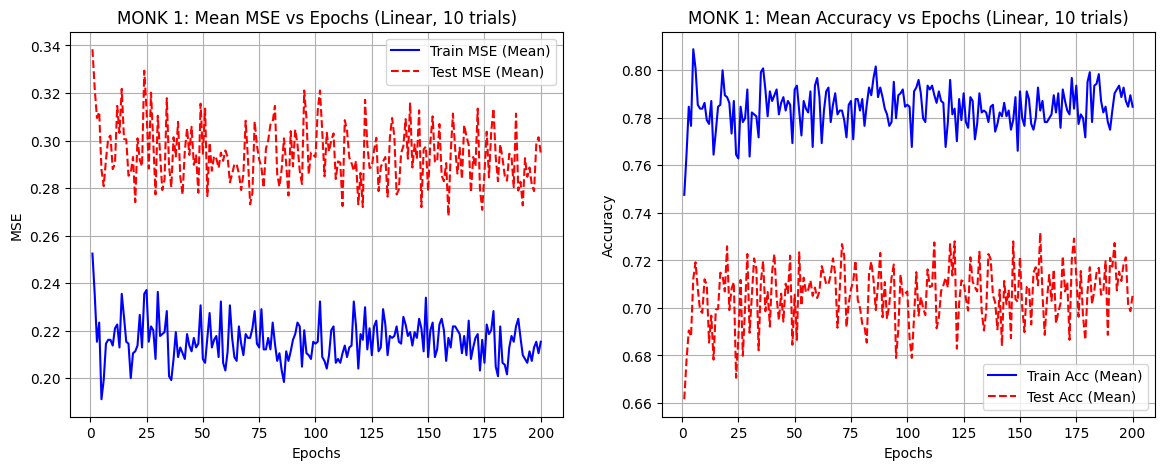

FINAL REPORT for MONK 1 (Linear Model - 10 Trials)
MSE (Train):      0.2153 ± 0.0304
MSE (Test):       0.2947  ± 0.0479
Accuracy (Train): 78.47% ± 3.04%
Accuracy (Test):  70.53%  ± 4.79%

==================== Processing MONK 2 (Linear SGD) ====================
Train shape: (169, 17), Test shape: (432, 17)
Starting Grid Search...
Best Params: {'eta0': 0.001, 'alpha': 0.0001} (CV Acc: 62.10%)
Running 10 independent trials for statistics...


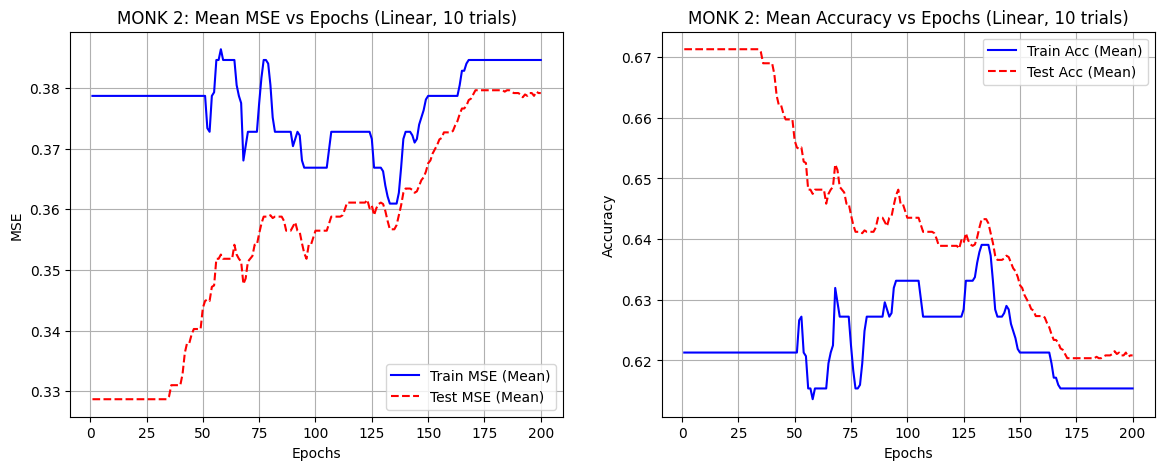

FINAL REPORT for MONK 2 (Linear Model - 10 Trials)
MSE (Train):      0.3846 ± 0.0000
MSE (Test):       0.3792  ± 0.0009
Accuracy (Train): 61.54% ± 0.00%
Accuracy (Test):  62.08%  ± 0.09%

==================== Processing MONK 3 (Linear SGD) ====================
Train shape: (122, 17), Test shape: (432, 17)
Starting Grid Search...
Best Params: {'eta0': 0.01, 'alpha': 0.0001} (CV Acc: 91.80%)
Running 10 independent trials for statistics...


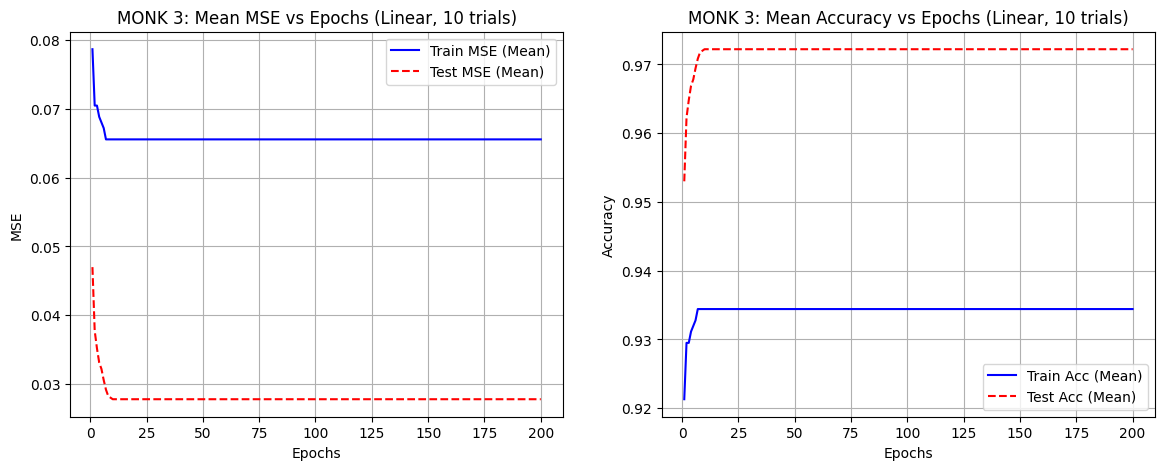

FINAL REPORT for MONK 3 (Linear Model - 10 Trials)
MSE (Train):      0.0656 ± 0.0000
MSE (Test):       0.0278  ± 0.0000
Accuracy (Train): 93.44% ± 0.00%
Accuracy (Test):  97.22%  ± 0.00%


In [45]:
run_monk_experiment(train_dataset=MonkDataset.MONK1_TRAIN, test_dataset=MonkDataset.MONK1_TEST, id_dataset=1)
run_monk_experiment(train_dataset=MonkDataset.MONK2_TRAIN, test_dataset=MonkDataset.MONK2_TEST, id_dataset=2)
run_monk_experiment(train_dataset=MonkDataset.MONK3_TRAIN, test_dataset=MonkDataset.MONK3_TEST, id_dataset=3)